File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
all_data          Naive Bayes        0.81            0.66            0.63            0.64            0.1201         


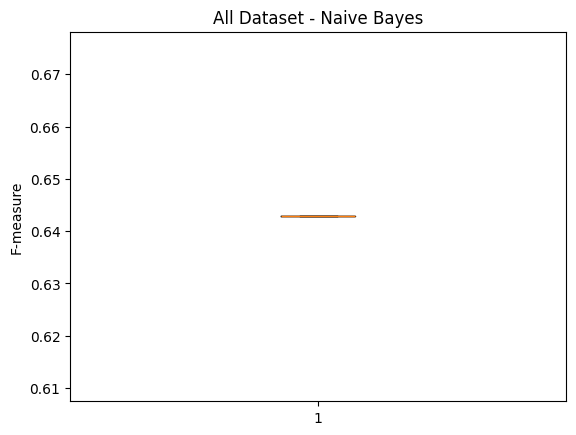

all_data          QDA                0.86            0.78            0.68            0.71            0.2155         


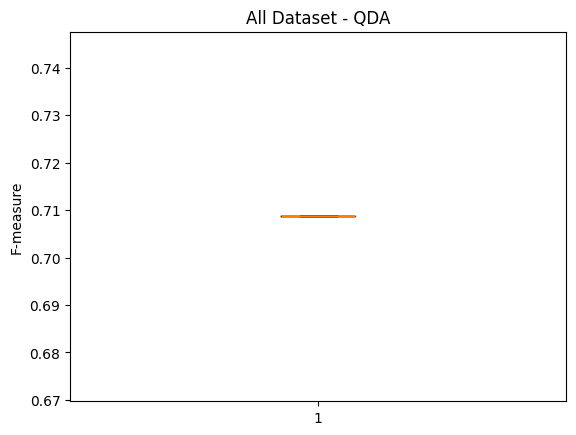

all_data          Random Forest      0.94            0.96            0.83            0.88            1.2629         


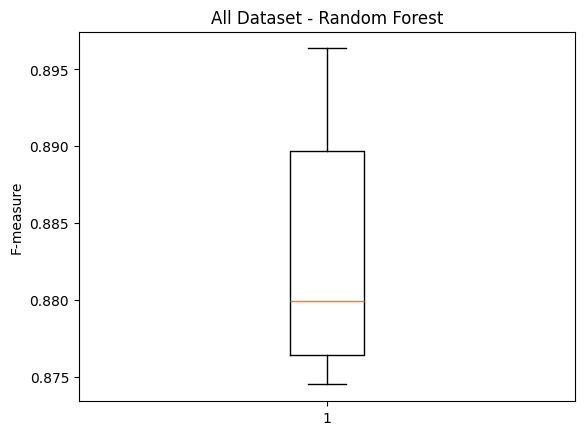

all_data          ID3                0.95            0.93            0.89            0.91            0.9517         


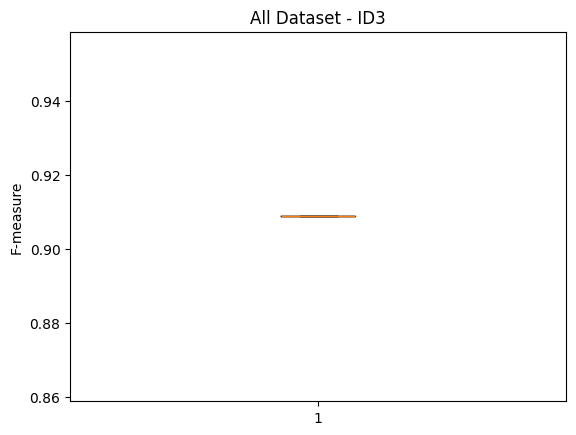

mission accomplished!
Total operation time: =  27.060861349105835 seconds


In [1]:
##  "all_data.csv" file is required for the operation of the program.
##  "all_data.csv" file must be located in the same directory as the program.

##  the purpose of this program is to apply machine learning algorithms to the dataset and observe the performance of algorithms.
##  the algorithms used are:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest Neighbors
##  As the program display output data include: file name, machine learning algorithm name, accuracy,Precision, Recall, F1-score,Time
##  the program will create a CSV file that prints the results and a folder containing graphics.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")

result = "./results/results_3.csv" # a CSV file is named in which the results are saved.
csv_files = ["all_data.csv"] # CSV files names: # The names of the dataset files (csv_files).
path = ""
repetition = 10

def folder(f_name): # this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print("The folder could not be created!")

folder_name = "./results/"
folder(folder_name)
folder_name = "./results/result_graph_3/"
folder(folder_name)

# The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list = {
    "Naive Bayes": GaussianNB(),
    "QDA": QDA(),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "ID3": DecisionTreeClassifier(max_depth=5, criterion="entropy")
    # "AdaBoost": AdaBoostClassifier(),
    # "MLP": MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=500),
    # "Nearest Neighbors": KNeighborsClassifier(3)
}

# list of all columns to be imported
# the 7 features with the highest importance weight selected by the file "04_2_feature_selection_for_attack_files.py" are used here. (+ Label Feature)
features = {"all_data": ["Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
                         "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total", "Label"]}

seconds = time.time() # time stamp for all processing time

with open(result, "w", newline="", encoding="utf-8") as f: # a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"])

for j in csv_files: # this loop runs on the list containing the filenames. Operations are repeated for all attack files
    print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time")) # print output header
    feature_list = list(features[j[0:-4]])
    df = pd.read_csv(path + j, usecols=feature_list) # read an attack file.
    df = df.fillna(0)
    attack_or_not = []
    for i in df["Label"]: # it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i == "BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)
    df["Label"] = attack_or_not

    y = df["Label"] # this section separates the label and the data into two separate pieces, as Label = y, Data = X
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    for ii in ml_list: # this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the algorithms
        precision = []
        recall = []
        f1 = []
        accuracy = []
        t_time = []
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second = time.time() # time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y, # data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train, 20% test).
                                                               test_size=0.20, random_state=repetition) # So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).

            # machine learning algorithm is applied in this section
            clf = ml_list[ii] # choose algorithm from ml_list dictionary
            clf.fit(X_train, y_train)
            predict = clf.predict(X_test)

            # makes "classification report" and assigns the precision, f-measure, and recall values.
            f_1 = f1_score(y_test, predict, average='macro')
            pr = precision_score(y_test, predict, average='macro')
            rc = recall_score(y_test, predict, average='macro')

            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time() - second)))

        print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4], ii, str(round(np.mean(accuracy), 2)), str(round(np.mean(precision), 2)),
                                                              str(round(np.mean(recall), 2)), str(round(np.mean(f1), 2)), str(round(np.mean(t_time), 4)))) # the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="", encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0, len(t_time)):
                wrt.writerow([j[0:-4], ii, accuracy[i], precision[i], recall[i], f1[i], t_time[i]]) # file name, algorithm name, precision, recall and f-measure are written in CSV file

        # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feature_graph folder.
        plt.boxplot(f1)
        plt.title("All Dataset - " + str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name + j[0:-4] + str(ii) + ".pdf", bbox_inches='tight', format='pdf') # Removed invalid arguments
        plt.show() # you can remove the # sign if you want to see the graphics simultaneously

print("mission accomplished!")
print("Total operation time: = ", time.time() - seconds, "seconds")
